# Experiments for evaluating embedding based models on our debiasing method for general image retrieval

In [1]:
from datasets import load_dataset, DatasetDict, Dataset
from transformers import BlipProcessor, BlipForConditionalGeneration, BlipForImageTextRetrieval, AutoTokenizer, AutoModelForMaskedLM, CLIPModel, CLIPProcessor
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

/data/scratch/fxwang/miniconda3/envs/mmalign/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda"

In [2]:
# directory to parquet of test data
test_parquet = "flickr30k_with_cliptop10_blip_captions.parquet"
# directory to parquet of train alignment data
train_parquet = "flickr30k_train_test_with_clip_embeddings.parquet"

In [4]:
test_data = load_dataset('parquet', data_files=test_parquet)
train_data = load_dataset('parquet', data_files=train_parquet)

In [5]:
text_embs_all = np.array(train_data["train"]["text_embeds"])
image_embs_all = np.array(train_data["train"]["image_embeds"])

In [6]:
train_indexes = np.where(np.array(train_data["train"]["split"]) == "train")[0]
test_indexes = np.where(np.array(train_data["train"]["split"]) != "train")[0]
alignment_text_embs = text_embs_all[train_indexes]
alignment_image_embs = image_embs_all[train_indexes]

In [7]:
clip_embeds = np.array(test_data["train"]["image_embeds"]).reshape(1000, 1, 1, 512)
text_embeds = np.array(test_data["train"]["text_embeds"]).reshape(1, 1000, 5, 512)

In [9]:
# image index, image index for caption, caption index
sim_scores = torch.tensor(np.sum(clip_embeds * text_embeds, axis=-1)).reshape(1000, 5000)

In [10]:
def top_k_results(scores, gt_index, num_k=None):
    if num_k is None:
        num_k = scores.shape[1]

    num_in_top_k = []
    for k in range(1, num_k+1):
        indices = torch.topk(scores, k, dim=1).indices
        in_top_k = ((indices == gt_index[:, None]).any(dim=1))
        num_in_top_k.append(in_top_k.sum().item())
    return np.array(num_in_top_k) / scores.shape[0]

In [11]:
def batched_scores_full(clip_embeds, text_embeds, batch_size=16):
    results = []
    for i in tqdm(range(0, len(clip_embeds), batch_size)):
        raw_scores = torch.sum(clip_embeds[i:i+batch_size] * text_embeds, dim=-1)
        reshaped = raw_scores.view(raw_scores.shape[0], -1)
        results.append(reshaped.to("cpu"))
    return torch.cat(results, dim=0)

In [12]:
clip_embeds = torch.tensor(clip_embeds, device=device)
alignment_text_embs = torch.tensor(alignment_text_embs, device=device)
alignment_image_embs = torch.tensor(alignment_image_embs, device=device)

In [13]:
with torch.inference_mode():
    scores_images = batched_scores_full(clip_embeds, alignment_text_embs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:03<00:00, 16.34it/s]


In [14]:
scores_images.shape

torch.Size([1000, 145000])

In [15]:
with torch.inference_mode():
    scores_images_negative = batched_scores_full(clip_embeds, alignment_image_embs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 90.74it/s]


In [16]:
scores_images_negative.shape

torch.Size([1000, 29000])

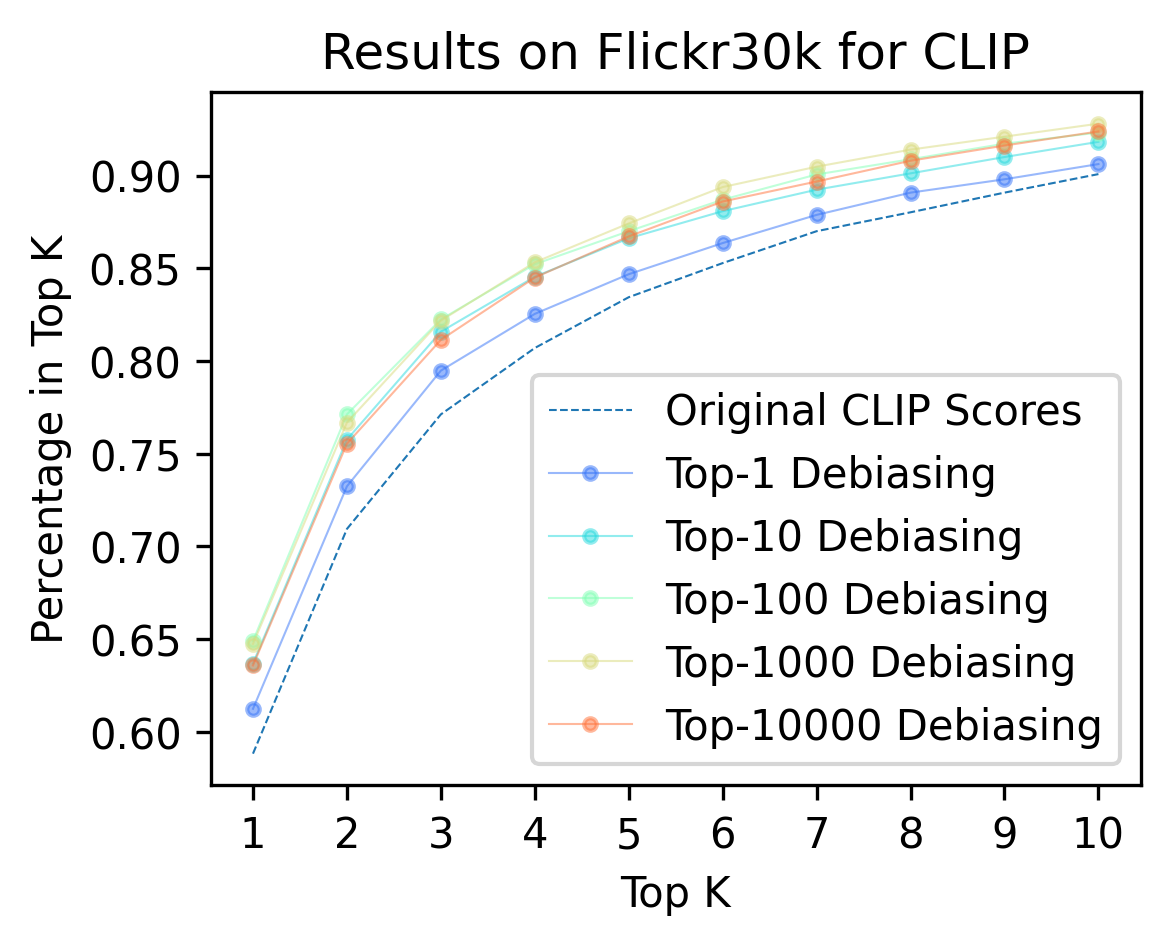

In [54]:
# graph for flickr30k clip
torch.inference_mode()
plt.figure(figsize=(4,3), dpi=300)

topk = top_k_results(sim_scores.reshape(1000, 5000).T, torch.tensor(np.arange(1000).repeat(5)), 10)
plt.plot(np.arange(1, 11), topk, label="Original CLIP Scores", ls="--", lw=0.5)

colors = plt.get_cmap('rainbow')(np.linspace(0.15, 0.85, 5))
for i, k in enumerate([1, 10, 100, 1000, 10000]):
    new_scores = sim_scores.reshape(1000, 5000) - torch.topk(scores_images, k, dim=-1).values.mean(dim=-1, keepdims=True)
    topk = top_k_results(new_scores.T, torch.tensor(np.arange(1000).repeat(5)), 10)
    plt.plot(np.arange(1, 11), topk, alpha=0.5, lw=0.5, color=colors[i], label=f"Top-{k} Debiasing", marker="o", markersize=3)

plt.xlabel("Top K")
plt.ylabel("Percentage in Top K")
plt.title("Results on Flickr30k for CLIP")
plt.xticks(np.arange(1, 11))
plt.legend(fontsize=10)